In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,TimeSeriesSplit


In [6]:
df = pd.read_csv('pr13_final_selected.csv')
print(df.shape)
print(df.columns)

(98916, 42)
Index(['Dividends', 'Stock Splits', 'Ticker', 'Industry_Tag', 'Country',
       'Close', 'Year', 'Month', 'Day', 'DayOfWeek', 'Day_Number',
       'Close_Lag_1', 'Volume_Lag_1', 'Days_Since_Lag_1', 'Close_Lag_2',
       'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5', 'Close_Lag_20',
       'Close_Lag_50', 'Close_Lag_80', 'Close_Lag_100', 'Weighted_Mean_2',
       'Weighted_Std_2', 'Weighted_Mean_3', 'Weighted_Std_3',
       'Weighted_Mean_4', 'Weighted_Std_4', 'Weighted_Mean_5',
       'Weighted_Std_5', 'Weighted_Mean_20', 'Weighted_Std_20',
       'Weighted_Mean_50', 'Weighted_Std_50', 'Weighted_Mean_80',
       'Weighted_Std_80', 'Weighted_Mean_100', 'Weighted_Std_100',
       'return_since_last_entry', 'diff_since_last_entry', 'Dividends_signal',
       'Stock Splits_signal'],
      dtype='object')


In [23]:
def split_data_by_time(df,test_percentage=0.2):
    df = df.sort_values(by='Day_Number')
    n_samples = df.shape[0]
    test_size = int(n_samples * test_percentage)

    train_df = df.iloc[:-test_size] 
    test_df = df.iloc[-test_size:]

    return train_df, test_df

In [24]:
train_df, test_df = split_data_by_time(df)
print(train_df.shape,test_df.shape)

(79133, 42) (19783, 42)


In [29]:
def create_X_y(df):
    X = df.drop(columns=["Close"])
    y = df["Close"]

    return X,y

X_train, y_train = create_X_y(train_df)
X_test, y_test = create_X_y(test_df)

numerical_cols = df.select_dtypes(include='float64').columns.tolist() 
numerical_cols.append('Day_Number')


all_columns = df.columns.tolist()
categorical_cols = list(set(all_columns) - set(numerical_cols))

numerical_cols.remove("Close")

print(categorical_cols)
print(numerical_cols)

['Year', 'Month', 'Industry_Tag', 'Ticker', 'Day', 'Dividends_signal', 'Country', 'Stock Splits_signal', 'DayOfWeek']
['Dividends', 'Stock Splits', 'Close_Lag_1', 'Volume_Lag_1', 'Days_Since_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5', 'Close_Lag_20', 'Close_Lag_50', 'Close_Lag_80', 'Close_Lag_100', 'Weighted_Mean_2', 'Weighted_Std_2', 'Weighted_Mean_3', 'Weighted_Std_3', 'Weighted_Mean_4', 'Weighted_Std_4', 'Weighted_Mean_5', 'Weighted_Std_5', 'Weighted_Mean_20', 'Weighted_Std_20', 'Weighted_Mean_50', 'Weighted_Std_50', 'Weighted_Mean_80', 'Weighted_Std_80', 'Weighted_Mean_100', 'Weighted_Std_100', 'return_since_last_entry', 'diff_since_last_entry', 'Day_Number']


In [ ]:
# def split_data_by_percentage_with_cv(df, test_percentage=0.2):
#     """
#     Splits the data into training and testing datasets based on the given percentage 
#     using TimeSeriesSplit with one split for each ticker.
    
#     Args:
#     - df (DataFrame): DataFrame containing 'Date', 'Ticker', and other columns like 'Price'.
#     - percentage (float): Percentage of data to be used for training. Defaults to 0.8 (80% for training, 20% for testing).
    
#     Returns:
#     - train_df (DataFrame): Training dataset with all tickers.
#     - test_df (DataFrame): Testing dataset with all tickers.
#     """
#     train_data = []
#     test_data = []

#     # Initialize TimeSeriesSplit with one split
#     tscv = TimeSeriesSplit(n_splits=5)

#     # Group by Ticker and iterate through each group
#     for ticker, group in df.groupby('Ticker'):
#         train_indices, test_indices = tscv.split(group)
#         print('train::',train_indices)
#         train, test = group.iloc[train_indices], group.iloc[test_indices]

#         # Append to the respective lists
#         train_data.append(train)
#         test_data.append(test)
        
#     # Concatenate all the individual train and test data for all tickers
#     train_df = pd.concat(train_data).sort_values(by='Date')
#     test_df = pd.concat(test_data).sort_values(by='Date')

#     return train_df, test_df

In [54]:

numeric_preprocessor = Pipeline([ 
    ("scaler", StandardScaler())
])                  

categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(sparse_output=False, drop='first',handle_unknown='infrequent_if_exist'))
])

preprocessor = ColumnTransformer([
    ("numerical",numeric_preprocessor, numerical_cols),
    ("categorical",categorical_preprocessor, categorical_cols)
    
], remainder='passthrough')

from xgboost import XGBRegressor

pipe = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',  XGBRegressor(random_state=0))
])

from scipy.stats import uniform as sp_uniform

param_grid = {
    'regressor__learning_rate': sp_uniform(loc=0.03, scale=0.07),
    'regressor__max_depth': [4, 5, 6, 7],
    'regressor__n_estimators': [300,400,500,600,700,800,900,1000]
}

cv = TimeSeriesSplit(n_splits=5)

grid_search = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=cv, random_state=0, n_jobs=-1,n_iter=15,error_score='raise' ,scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)



print(pipe.get_params())
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print('Best parameters:',best_params)

{'memory': None, 'steps': [('preprocessor', ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Dividends', 'Stock Splits', 'Close_Lag_1',
                                  'Volume_Lag_1', 'Days_Since_Lag_1',
                                  'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4',
                                  'Close_Lag_5', 'Close_Lag_20', 'Close_Lag_50',
                                  'Close_Lag_80', 'Close_Lag_100',
                                  'Weighted_Mean_2', 'Weighted_Std_2',
                                  'Weighte...
                                  'Weighted_Mean_50', 'Weighted_Std_50',
                                  'Weighted_Mean_80', 'Weighted_Std_80',
                                  'Weighted_Mean_100', 'Weighted_Std_100',
                                  'return_since_last_entry', ...]),
     

c:\Users\timmv\anaconda3\envs\ml2025\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


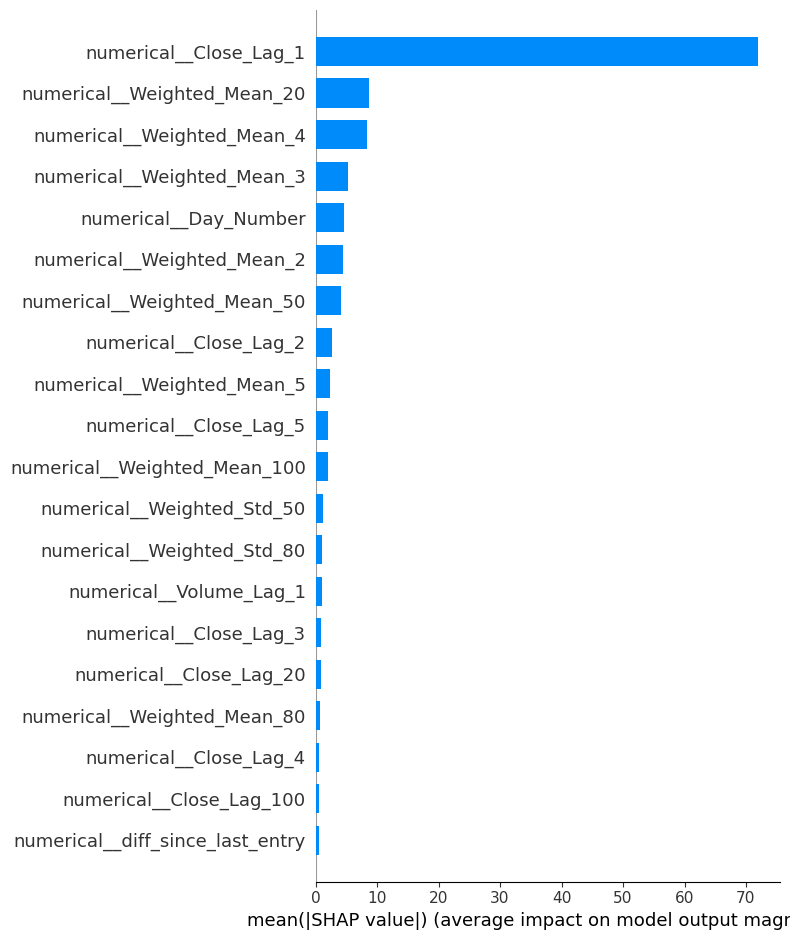

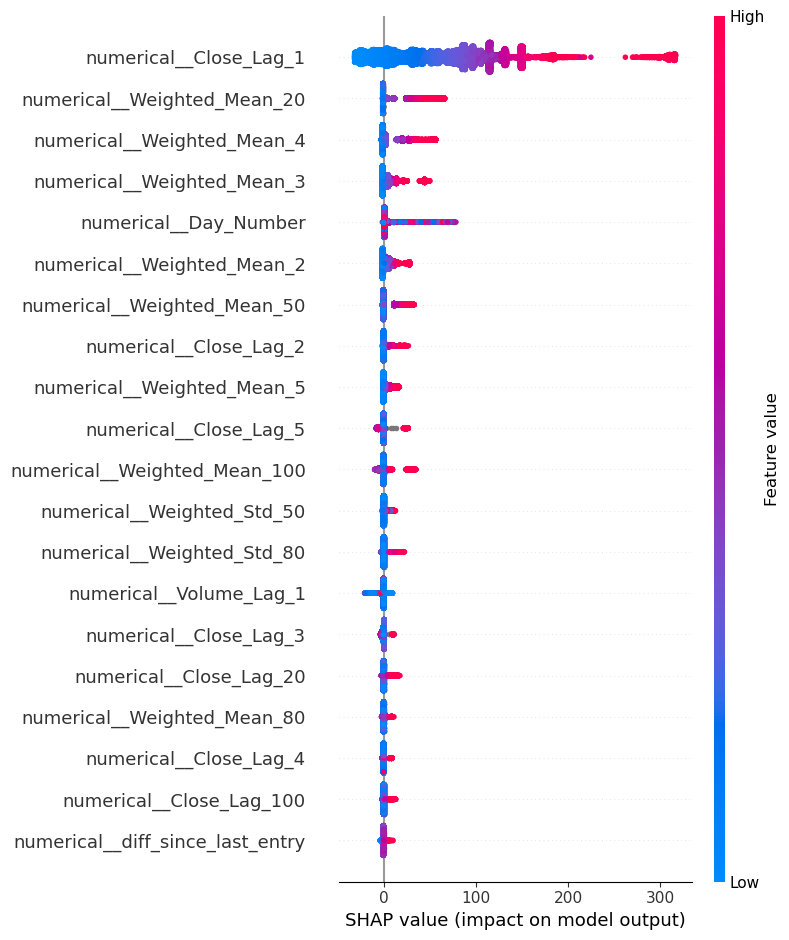

                         feature  mean_abs_shap_importance
2         numerical__Close_Lag_1                 71.934013
21   numerical__Weighted_Mean_20                  8.619776
17    numerical__Weighted_Mean_4                  8.370795
15    numerical__Weighted_Mean_3                  5.270109
31         numerical__Day_Number                  4.614681
..                           ...                       ...
252         categorical__Day_115                  0.000000
251         categorical__Day_114                  0.000000
250         categorical__Day_113                  0.000000
249         categorical__Day_112                  0.000000
258         categorical__Day_121                  0.000000

[516 rows x 2 columns]

Calculating Permutation Importance...


c:\Users\timmv\anaconda3\envs\ml2025\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


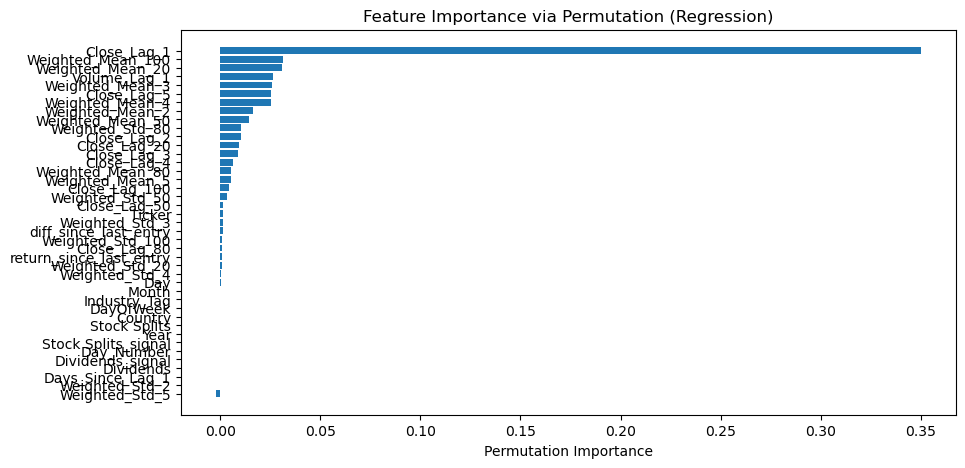

In [41]:
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

best_model = grid_search.best_estimator_

explainer_shap = shap.TreeExplainer(best_model.named_steps['regressor'])
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_processed = best_model.named_steps['preprocessor'].transform(X_test)

shap_values = explainer_shap.shap_values(X_processed)
shap.summary_plot(shap_values, X_processed, feature_names=feature_names,plot_type="bar")
shap.summary_plot(shap_values, X_processed,feature_names=feature_names,plot_type="dot")

mean_shap_importance = np.abs(shap_values).mean(axis=0)

# Combine into a DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap_importance': mean_shap_importance
})

# Sort by importance descending
feature_importance_df = feature_importance_df.sort_values(by='mean_abs_shap_importance', ascending=False)

# Show it
print(feature_importance_df)

def evaluate_shap_feature_importance(model, X):
    """
    Evaluate feature importance using SHAP for tree-based regression models.

    Parameters:
    - model: trained tree-based regression model
    - X: features (DataFrame)

    Returns:
    - None (plots SHAP feature importance results)
    """

    print("\nCalculating SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    print("\nPlotting SHAP summary (bar)...")
    shap.summary_plot(shap_values, X, plot_type="bar")

    print("\nPlotting SHAP summary (beeswarm)...")
    shap.summary_plot(shap_values, X, plot_type="dot")



def evaluate_permutation_feature_importance(model, X, y, n_repeats=30, random_state=0):
    """
    Evaluate feature importance using Permutation Importance for tree-based regression models.

    Parameters:
    - model: trained tree-based regression model
    - X: features (DataFrame)
    - y: target values
    - n_repeats: number of shuffles for stability
    - random_state: random seed

    Returns:
    - None (plots permutation feature importance)
    """

    print("\nCalculating Permutation Importance...")
    perm_result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=-1)

    sorted_idx = perm_result.importances_mean.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(X.columns[sorted_idx], perm_result.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance via Permutation (Regression)")
    plt.show()


# Example usage after training:
# evaluate_shap_feature_importance(model=best_model.named_steps['regressor'], X=X_test)
evaluate_permutation_feature_importance(model=best_model, X=X_test, y=y_test)

In [55]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform as sp_uniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Numeric and categorical columns as you have defined them
numeric_preprocessor = Pipeline([ 
    ("scaler", StandardScaler())
])                  

categorical_preprocessor = Pipeline([])  # No encoding needed for CatBoost

preprocessor = ColumnTransformer([
    ("numerical", numeric_preprocessor, numerical_cols),
    ("categorical", 'passthrough', categorical_cols)
], remainder='passthrough')

# Set up the pipeline with CatBoostRegressor
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',  CatBoostRegressor(random_state=0, cat_features=list(range(len(numerical_cols), len(numerical_cols) + len(categorical_cols))))) #order changes after preprocessor
])


# Param grid for RandomizedSearchCV
param_grid = {
    'regressor__learning_rate': sp_uniform(loc=0.03, scale=0.07),
    'regressor__depth': [4, 5, 6, 7],
    'regressor__iterations': [300, 400, 500, 600, 700, 800, 900, 1000]
}

# Set up TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)

# Set up RandomizedSearchCV
grid_search = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=cv, random_state=0, n_jobs=-1, n_iter=15, error_score='raise', scoring='neg_root_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters
best_params = grid_search.best_params_
print('Best parameters:', best_params)


0:	learn: 56.8026027	total: 277ms	remaining: 3m 41s
1:	learn: 52.2952731	total: 418ms	remaining: 2m 46s
2:	learn: 48.1133702	total: 574ms	remaining: 2m 32s
3:	learn: 44.2783025	total: 727ms	remaining: 2m 24s
4:	learn: 40.8249257	total: 1.01s	remaining: 2m 40s
5:	learn: 37.6123166	total: 1.25s	remaining: 2m 45s
6:	learn: 34.6716311	total: 1.46s	remaining: 2m 45s
7:	learn: 31.9727049	total: 1.67s	remaining: 2m 45s
8:	learn: 29.5269428	total: 1.87s	remaining: 2m 44s
9:	learn: 27.2704249	total: 2.08s	remaining: 2m 44s
10:	learn: 25.1768060	total: 2.27s	remaining: 2m 42s
11:	learn: 23.2926397	total: 2.47s	remaining: 2m 42s
12:	learn: 21.5377134	total: 2.65s	remaining: 2m 40s
13:	learn: 19.9177101	total: 2.83s	remaining: 2m 38s
14:	learn: 18.4595408	total: 3.01s	remaining: 2m 37s
15:	learn: 17.1288673	total: 3.17s	remaining: 2m 35s
16:	learn: 15.9133558	total: 3.35s	remaining: 2m 34s
17:	learn: 14.7815916	total: 3.54s	remaining: 2m 33s
18:	learn: 13.7568315	total: 3.71s	remaining: 2m 32s
19:

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform as sp_uniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Numeric and categorical columns as you have defined them
numeric_preprocessor = Pipeline([ 
    ("scaler", StandardScaler())
])                  

categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(sparse_output=False, drop='first',handle_unknown='infrequent_if_exist'))
])  

preprocessor = ColumnTransformer([
    ("numerical", numeric_preprocessor, numerical_cols),
    ("categorical", categorical_preprocessor, categorical_cols)
], remainder='passthrough')

# Set up the pipeline with RandomForestRegressor
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',  RandomForestRegressor(random_state=0))
])

# Param grid for RandomizedSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300, 400, 500, 600],
    'regressor__max_depth': [4, 5, 6, 7, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
}

# Set up TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)

# Set up RandomizedSearchCV
grid_search = RandomizedSearchCV(pipe, param_distributions=param_grid, cv=cv, random_state=0, n_jobs=-1, n_iter=15, error_score='raise', scoring='neg_root_mean_squared_error')

X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train[X_train_cleaned.index]
# Fit the model
grid_search.fit(X_train_cleaned, y_train_cleaned)

# Print best parameters
best_params = grid_search.best_params_
print('Best parameters:', best_params)


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def evaluate_model(model, X_test, y_test, benchmark_column='Close_Lag_1'):
    """
    Evaluate a regression model with various metrics and compare it to a benchmark.
    
    Parameters:
    X : pd.DataFrame
        The input features for training the model.
    y : pd.Series or np.array
        The target variable for training the model.
    model : sklearn model
        The trained regression model (e.g., LinearRegression).
    X_test : pd.DataFrame
        The test features for evaluating the model.
    y_test : pd.Series or np.array
        The true target values for the test set.
    benchmark_column : str, optional
        The column name to be used as the benchmark (default is 'Close_Lag_1').
    
    Returns:
    None
    """
    # Predict with the model
    y_test_pred = model.predict(X_test)
    
    # Compute the metrics
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    R_2_test = r2_score(y_test, y_test_pred)
    adj_R2_test = 1 - ((1 - R_2_test) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
    
    # Benchmark prediction (using Close_Lag_1 as the benchmark)
    y_pred_benchmark = X_test[benchmark_column]
    mse_benchmark = mean_squared_error(y_test, y_pred_benchmark)
    mae_benchmark = mean_absolute_error(y_test, y_pred_benchmark)
    mape_benchmark = mean_absolute_percentage_error(y_test, y_pred_benchmark)
    R_2_benchmark = r2_score(y_test, y_pred_benchmark)
    adj_R2_benchmark = 1 - ((1 - R_2_benchmark) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
    
    # Print model evaluation metrics
    print("---- Model Evaluation ----")
    print("Mean Squared Error on test set:", mse_test)
    print("Root Mean Squared Error on test set:", np.sqrt(mse_test))
    print("Mean Absolute Error on test set:", mae_test)
    print("Mean Absolute Percentage Error on test set:", mape_test)
    print("R^2 on test set:", R_2_test)
    print("Adjusted R^2 on test set:", adj_R2_test)
    
    # Print benchmark comparison
    print("\n---- Benchmark Comparison ----")
    print("Mean Squared Error on benchmark:", mse_benchmark)
    print("Root Mean Squared Error on benchmark:", np.sqrt(mse_benchmark))
    print("Mean Absolute Error on benchmark:", mae_benchmark)
    print("Mean Absolute Percentage Error on benchmark:", mape_benchmark)
    print("R^2 on benchmark:", R_2_benchmark)
    print("Adjusted R^2 on benchmark:", adj_R2_benchmark)